# Import Packages

In [1]:
import cv2
import copy
import math
import scipy.io
import scipy as sp
import numpy as np
from time import time
from PIL import Image

import utils.plotFunctions as pf
import utils.helperFunctions as hf
from utils.lcaFunctions import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import sparse_encode
from sklearn.decomposition import MiniBatchDictionaryLearning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, models

# Generate Dictionary and Sparse Codes

## Load CIFAR10 patches

Original CIFAR shape: (50000, 16, 8, 8)
Flattened CIFAR shape: (800000, 64)


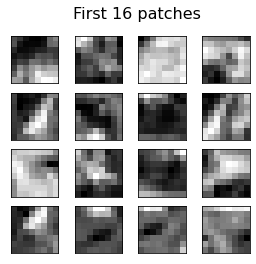

In [2]:
# Load .npy patches
cifar_patches = np.load('./CIFAR_patches.npy')
print("Original CIFAR shape: {}".format(cifar_patches.shape))

# Flatten patches for dictionary learning
patches_flat = cifar_patches.reshape(cifar_patches.shape[0], 16, -1) / 255.
cifar_patches_flattened = patches_flat.reshape(-1, patches_flat.shape[-1])
print("Flattened CIFAR shape: {}".format(cifar_patches_flattened.shape))

# Normalize patches
mean = np.mean(cifar_patches_flattened, axis=0)
std = np.std(cifar_patches_flattened, axis=0)

cifar_patches_flattened -= mean
cifar_patches_flattened /= std
np.save('./CIFAR_patches_flattened.npy', cifar_patches_flattened)

# Plot figure of first 16 pictures
plt.figure(figsize = (4, 4))
for i, patch in enumerate(cifar_patches[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(patch, cmap = "gray")
    plt.xticks(())
    plt.yticks(())
    
plt.suptitle('First 16 patches', fontsize=16)
plt.subplots_adjust(0.05)

### LCA

In [3]:
# Sparse Coding hyperparameters
lambdav = 0.1 # Value set by myself
batchSize = 50  # Number of samples to use in a single weight update
eta = 0.1  # Learning rate
numTrials = 2500  # Number of weight update steps

# Inference hyperparameters
tau = 100 # LCA update time constant
numInferenceSteps = 400 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 50  # How often to update display plots during learning
displayStatsInterval = 50  # How often to update the stats plots

# Dataset specific hyperparameters
numInputs = 64
numOutputs = 128 # Number of neurons
numDataPoints = 64000

In [4]:
#Functions from Berkley, Neural Computation, lab 4
def threshold(u, lambdav):                                                                                                                                                                                                          
    """   
    Compute the activity of the neurons using the membrane potentials (u) using soft thresholding:                                                                                                                                           
                                                                                                                                                                                                                                         
    a = T(u) = u - threshold, u > threshold                                                                                                                                                                                              
               u + threshold, u < -threshold                                                                                                                                                                                             
               0, otherwise                                                                                                                                                                                                              
    """
    a = np.abs(u) - lambdav                                                                                                                                                                                                            
    a[np.where(a<0)] = 0          
    a = np.sign(u) * a    
    a[np.where(a<0)] = 0 #Non-negative only
    return a

def inference(dataBatch, phi, tau, lambdav, numInferenceSteps):
    """
    Compute

    Parameters
    ----------
    dataBatch : Batch of data samples, shape=(numInputs, batchSize) 
    phi : Dictionary, shape=(numInputs, numOutputs)
    tau : Time Constant of LCA update, scalar float
    lambdav : Both the sparsity tradeoff term and the LCA Threshold value
    numInferencSteps: Number of inference steps to take
    
    Returns
    -------
    a : Activity, i.e. thresholded potentials, shape=(numOutputs, batchSize)
    """
    u_history = [] # List of membrane potentials recorded at each integer 2^i
    
    b = phi.T @ dataBatch # Driving input
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix
    u = np.zeros_like(b) # Initialize membrane potentials to 0
    
    for step in range(numInferenceSteps):
        a = threshold(u, lambdav) # Activity vector contains thresholded membrane potentials
        du = b - u - (gramian @ a)
        u += (1.0 / tau) * du # Update membrane potentials using time constant
        
        # If step is a power of 2 (2, 4, 6... 256... numInferenceSteps), record membrane potentials
        if step != 0 and (math.ceil(np.log2(step)) == math.floor(np.log2(step))) or step == (numInferenceSteps - 1): 
            #print("Recording membrane potentials at step: ", step)
            u_history.append(u)
            
    return u_history, threshold(u, lambdav)

def weightUpdate(phi, dataBatch, activity, learningRate):
    dataBatchReconstruction = phi @ activity
    reconstructionError = dataBatch - dataBatchReconstruction
    dPhi = reconstructionError @ activity.T # Weight update rule (dE/dPhi)
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconstructionError)


# Computes dictionary with LCA
# Function from Berkley, Neural Computation, lab 4
def trainModel(dataset):
    t0 = time()
    # Plotting
    sumPercentNonZero, sumEnergy, sumReconstructionQualitySNR = 0, 0, 0
    statsFig, statsAxes = pf.plotStats(numTrials)
    
    # Initialize phi weight matrix randomly
    phi = hf.l2Norm((np.random.randn(numInputs, numOutputs) * 2) - 1)
    
    # Sparse coding with LCA
    for trial in range(numTrials):
        # Make batch of random images
        dataBatch = np.zeros((numInputs, batchSize))
        for batchNum in range(batchSize):
            dataBatch[:, batchNum] = dataset[np.random.randint(dataset.shape[0])]
            
        # Compute sparse code for batch of data samples
        _, activity = inference(dataBatch, phi, tau, lambdav, numInferenceSteps)

        # Update weights using inferred sparse activity
        learningRate = eta / batchSize
        (phi, reconstructionError) = weightUpdate(phi, dataBatch, activity, learningRate)

        # Renormalize phi matrix
        phi = hf.l2Norm(phi)

        # Record stats for plotting
        percentNonZero, energy, reconstructionQualitySNR = (
            hf.computePlotStats(activity, reconstructionError, lambdav))
        sumPercentNonZero += percentNonZero
        sumEnergy += energy
        sumReconstructionQualitySNR += reconstructionQualitySNR

        if trial and trial % displayStatsInterval == 0:
            avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR = (
                sumEnergy/ displayStatsInterval, sumPercentNonZero / displayStatsInterval, 
                sumReconstructionQualitySNR / displayStatsInterval)
            pf.updateStats(statsFig, statsAxes, trial, avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR)
            sumPercentNonZero = 0
            sumEnergy = 0
            sumReconstructionQualitySNR = 0
    dt = time() - t0    
    print("Dictionary learned in: ", dt)
            
    return phi

## Learn dictionaries with LCA

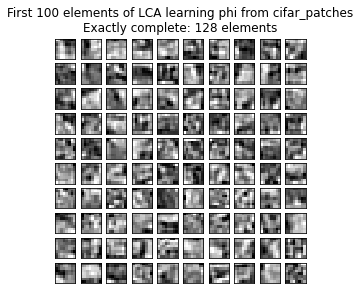

In [14]:
phi_128 = trainModel(cifar_patches_flattened)
print("Dictionary: {}".format(phi_128.shape))
np.save('./phi_128.npy', phi_128)

# Plot first 100 elements of dictionary
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(phi_128.T[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap='gray',
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('First 100 elements of LCA learning phi from cifar_patches\n' + "Exactly complete: 128 elements\n",
             fontsize=12)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.87, 0.08, 0.23)
plt.savefig('lca_sparse_coding_summary_statistics.png')

## Approximate Sparse Codes with LCA

In [6]:
#Training set used to learn dictionaries
t0 = time()
print("Inferring LCA sparse code of training with complete (128 element) dictionary...")
uhist_128, lca_128 = inference(cifar_patches_flattened.T, phi_128, tau, lambdav, numInferenceSteps) # cifar_train.T because shape=(numInputs, batchSize) 
dt = time() - t0
print('done in %.2fs.' % dt)
lca_128 = lca_128.T
np.save('./lca_128.npy', lca_128)

Inferring LCA sparse code of training with complete (128 element) dictionary...
done in 1394.61s.


## Reconstruct sparse codes

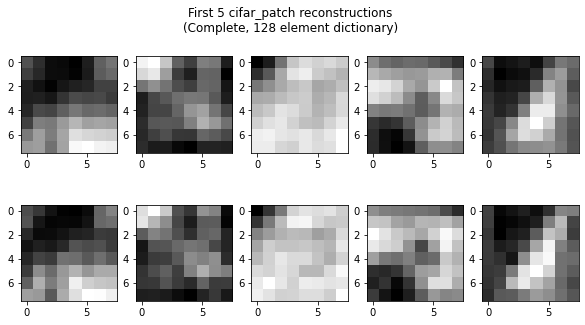

In [11]:
lca_recon_128 = np.dot(lca_128, phi_128.T)
lca_recon_128 = lca_recon_128.reshape(len(lca_128), 8 , 8)

# Generate plot
f, axarr = plt.subplots(2, 5)
f.set_size_inches(10, 5)
for i in range(5):
    axarr[0,i].imshow(lca_recon_128[i], cmap = 'gray')
    axarr[1,i].imshow(cifar_patches[0][i], cmap = 'gray')
plt.suptitle("First 5 cifar_patch reconstructions\n(Complete, 128 element dictionary)")
plt.savefig('cifar_patch_reconstruction.png')